# Multivariate Gaussian Mixture Density Estimation 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.style.use('ggplot')

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
single_plot_fig_size = (7,4)
legend_loc = None
legend_framealpha = 0.8
subplot_adjust_bottom = 0.2

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp

# set tf logger to log level ERROR to avoid warnings
tf.get_logger().setLevel('ERROR')

tfd = tfp.distributions
tfb = tfp.bijectors
tfk = tf.keras

In [3]:
import fastprogress
from bayes_vi.utils.symplectic_integrators import LeapfrogIntegrator
from bayes_vi.inference.vi.flow_bijectors import HamiltonianFlow, AffineFlow, make_energy_fn, make_scale_fn, make_shift_fn

## 1. Generate Test Data from Multivariate Gaussian Mixture Distribution

In [4]:
# generate parameters for the "true" underlying mixture model
num_datapoints = 10000

true_component_n = 4
dims = 2

fill_scale_tril = tfb.FillScaleTriL(diag_bijector=tfb.Softplus(), diag_shift=1.)

true_locs = tf.constant(np.random.choice(a=list(range(-20,20+1)), size=(true_component_n, dims)), dtype=tf.float32)

true_scales = tf.round(fill_scale_tril(
    tf.random.normal((true_component_n, dims*(dims+1)//2)))
)

selected_component = np.random.randint(0, true_component_n, 50)
true_component_weights = tf.constant(np.histogram(a=selected_component, bins=np.arange(true_component_n+1))[0]/selected_component.size, dtype=tf.float32)

In [5]:
true_component_weights, true_locs, true_scales

(<tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.28, 0.22, 0.28, 0.22], dtype=float32)>,
 <tf.Tensor: shape=(4, 2), dtype=float32, numpy=
 array([[ -7., -12.],
        [  2.,   0.],
        [ 10.,  14.],
        [ -6.,  14.]], dtype=float32)>,
 <tf.Tensor: shape=(4, 2, 2), dtype=float32, numpy=
 array([[[ 1.,  0.],
         [ 1.,  2.]],
 
        [[ 2.,  0.],
         [ 1.,  1.]],
 
        [[ 2.,  0.],
         [-2.,  2.]],
 
        [[ 1.,  0.],
         [ 1.,  1.]]], dtype=float32)>)

In [6]:
# create data generating mixture of gaussians
true_mvns = tfd.MultivariateNormalTriL(true_locs, true_scales)

true_mixture = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(probs=true_component_weights),
    components_distribution=true_mvns
)

# generate data points by sampling from the distribution
y = true_mixture.sample(num_datapoints)
y

<tf.Tensor: shape=(10000, 2), dtype=float32, numpy=
array([[ -8.651967 , -13.346855 ],
       [  6.9432173,  15.120493 ],
       [  3.1351895,   1.3659804],
       ...,
       [ -6.840503 , -13.772652 ],
       [ -5.6946125,  12.831047 ],
       [  4.1396303,   1.8088615]], dtype=float32)>

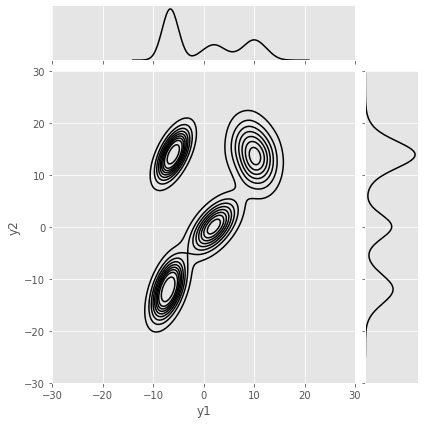

In [7]:
data = {'y1': y[:,0].numpy(), 'y2':y[:,1].numpy()}
ax = sns.jointplot(data=data, x='y1', y='y2', kind='kde', xlim=(-30, 30), ylim=(-30, 30), color='black')

In [8]:
dataset = tf.data.Dataset.from_tensor_slices(y)

In [9]:
epochs = 50
batch_size = 50
sample_size = 10
optimizer = tf.optimizers.Adam(learning_rate=1e-3)

## 2. Construct Variational Families

### Construct Hamiltonian Normalizing Flow

In [10]:
base_dist = tfd.MultivariateNormalDiag(loc=tf.Variable(tf.zeros(shape=(dims*2,))), scale_diag=tf.Variable(tf.ones(dims*2)*10.0))

loc_fn = make_shift_fn(dims, hidden_layers=[128,128])
scale_fn = make_scale_fn(dims, hidden_layers=[128,128])

encoder = lambda q: tfd.MultivariateNormalDiag(loc=loc_fn(q), scale_diag=scale_fn(q))

In [11]:
num_flows = 3
hnf = tfd.TransformedDistribution(
    base_dist, 
    bijector=tfb.Chain([
        tfb.Split(2, axis=-1),
        *[HamiltonianFlow(
            event_dims=dims,
            symplectic_integrator=LeapfrogIntegrator(), 
            step_sizes=tf.Variable(0.1), 
            num_integration_steps=2,
            hidden_layers=[128, 128]
        ) for _ in range(num_flows)]
        
    ])
)

### Construct Meanfield ADVI and Affine Flow

In [12]:
base_dist = tfd.MultivariateNormalDiag(loc=tf.Variable(tf.zeros(shape=(dims,))), scale_diag=tf.Variable(tf.ones(dims)*10.0))

affine_flow = tfd.TransformedDistribution(
    base_dist,
    bijector=AffineFlow(dims)
)

### Construct Continuous normalizing flow

In [13]:
def get_continuous_flow_bijector(unconstrained_event_dims):
    state_fn = tfk.Sequential()
    state_fn.add(tfk.layers.Dense(128, activation=tfk.activations.tanh))
    state_fn.add(tfk.layers.Dense(128, activation=tfk.activations.tanh))
    state_fn.add(tfk.layers.Dense(unconstrained_event_dims))
    state_fn.build((None, unconstrained_event_dims+1))
    state_time_derivative_fn = lambda t, state: state_fn(tf.concat([tf.fill((state.shape[0],1), t), state], axis=-1))
    return tfb.FFJORD(state_time_derivative_fn, 
                      ode_solve_fn=tfp.math.ode.DormandPrince(first_step_size=0.1).solve, 
                      trace_augmentation_fn=tfb.ffjord.trace_jacobian_hutchinson)

base_dist = tfd.MultivariateNormalDiag(loc=tf.Variable(tf.zeros(shape=(dims,))), scale_diag=tf.Variable(tf.ones(dims)*10.0))

cnf = tfd.TransformedDistribution(
    base_dist,
    bijector=get_continuous_flow_bijector(dims)
)

## 3. Fit Variational Families to Data

### Train Hamiltonian Normalizing Flow

In [14]:
@tf.function(autograph=False)
def optimizer_step(q):
    
    with tf.GradientTape() as tape:
        cond_dist = encoder(q)
        p = cond_dist.sample(sample_size)
        loss = - tf.reduce_mean(hnf.log_prob([tf.stack([q]*sample_size, axis=0),p]) - cond_dist.log_prob(p))
    
    grads = tape.gradient(loss, tape.watched_variables())
    optimizer.apply_gradients(zip(grads, tape.watched_variables()))
    return loss

In [15]:
%%time
hnf_losses = []
i=0
ep = fastprogress.master_bar(range(epochs))
for _ in ep:
    data_generator = dataset.shuffle(batch_size*100).batch(batch_size=batch_size)
    batches = fastprogress.progress_bar(data_generator, parent=ep)
    for q in batches:
        i += 1 
        loss = optimizer_step(q)
        hnf_losses.append(loss.numpy())
    ep.main_bar.comment = "avg loss: {:.3f}".format(np.mean(hnf_losses[max(0, i - 100):i + 1]))


CPU times: user 11min 6s, sys: 2min 52s, total: 13min 59s
Wall time: 5min 59s


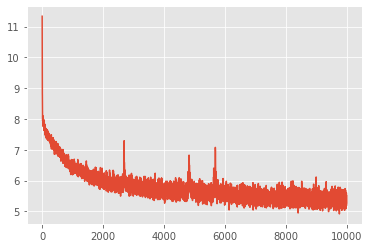

In [16]:
plt.plot(hnf_losses)

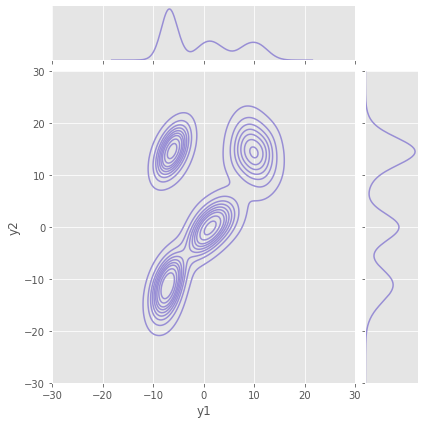

In [17]:
sample = hnf.sample(10000)[0]
data = {'y1': sample[:,0].numpy(), 'y2':sample[:,1].numpy()}
ax = sns.jointplot(data=data, x='y1', y='y2', kind='kde', xlim=(-30, 30), ylim=(-30, 30), color=colors[2])

### Train Affine Flow

In [18]:
@tf.function(autograph=False)
def optimizer_step(q, dist):
    
    with tf.GradientTape() as tape:
        loss = - tf.reduce_mean(dist.log_prob(q))
    
    grads = tape.gradient(loss, tape.watched_variables())
    optimizer.apply_gradients(zip(grads, tape.watched_variables()))
    return loss

In [19]:
%%time
affine_losses = []
i=0
ep = fastprogress.master_bar(range(epochs))
for _ in ep:
    data_generator = dataset.shuffle(batch_size*100).batch(batch_size=batch_size)
    batches = fastprogress.progress_bar(data_generator, parent=ep)
    for q in batches:
        i += 1 
        loss = optimizer_step(q, affine_flow)
        affine_losses.append(loss.numpy())
    ep.main_bar.comment = "avg loss: {:.3f}".format(np.mean(affine_losses[max(0, i - 100):i + 1]))


CPU times: user 11.4 s, sys: 1.13 s, total: 12.5 s
Wall time: 8.66 s


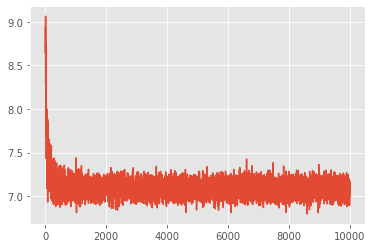

In [20]:
plt.plot(affine_losses)

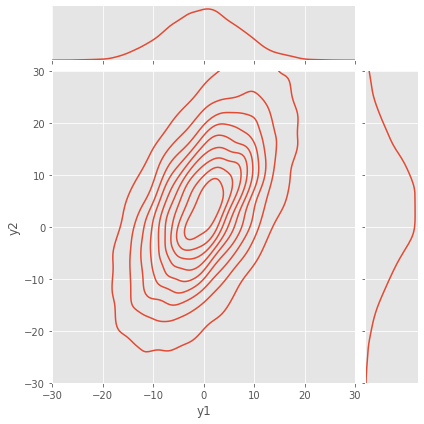

In [21]:
sample = affine_flow.sample(10000)
data = {'y1': sample[:,0].numpy(), 'y2':sample[:,1].numpy()}
ax = sns.jointplot(data=data, x='y1', y='y2', kind='kde', xlim=(-30, 30), ylim=(-30, 30), color=colors[0])

### Train Continuous Normalizing Flow

In [22]:
@tf.function(autograph=False)
def optimizer_step(q, dist):
    
    with tf.GradientTape() as tape:
        loss = - tf.reduce_mean(dist.log_prob(q))
    
    grads = tape.gradient(loss, tape.watched_variables())
    optimizer.apply_gradients(zip(grads, tape.watched_variables()))
    return loss

In [23]:
%%time
cnf_losses = []
i=0
ep = fastprogress.master_bar(range(epochs))
for _ in ep:
    data_generator = dataset.shuffle(batch_size*100).batch(batch_size=batch_size)
    batches = fastprogress.progress_bar(data_generator, parent=ep)
    for q in batches:
        i += 1 
        loss = optimizer_step(q, cnf)
        cnf_losses.append(loss.numpy())
    ep.main_bar.comment = "avg loss: {:.3f}".format(np.mean(cnf_losses[max(0, i - 100):i + 1]))


CPU times: user 20min 18s, sys: 2min 38s, total: 22min 56s
Wall time: 8min 14s


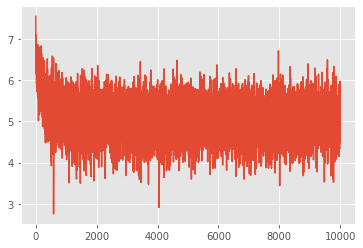

In [24]:
plt.plot(cnf_losses)

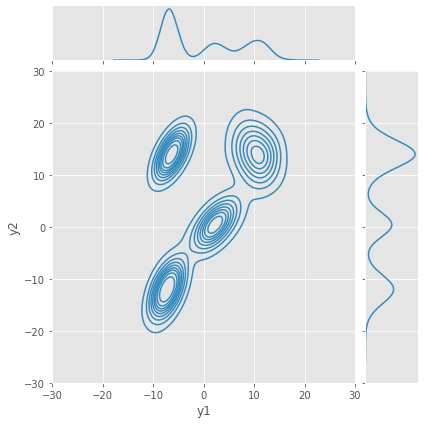

In [25]:
sample = cnf.sample(10000)
data = {'y1': sample[:,0].numpy(), 'y2':sample[:,1].numpy()}
ax = sns.jointplot(data=data, x='y1', y='y2', kind='kde', xlim=(-30, 30), ylim=(-30, 30), color=colors[1])

In [26]:
loss_df = pd.DataFrame({'affine flow': affine_losses, 'cnf': cnf_losses, 'hnf(3)': hnf_losses})

(0.0, 15.0)

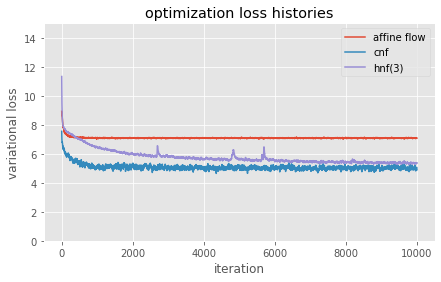

In [29]:
fig, ax = plt.subplots(1,1, figsize=single_plot_fig_size)
ax = loss_df.ewm(alpha=0.1).mean().plot(title='optimization loss histories', xlabel='iteration', ylabel='variational loss', ax=ax)
ax.set_ylim((0, 15))

In [30]:
loss_df[-100:].mean()

affine flow    7.085147
cnf            5.003199
hnf(3)         5.359770
dtype: float64